In [ ]:
###Changes done, just have to try running at this config

In [ ]:
!nvidia-smi

Sat Sep 26 17:35:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#fetching dataset from zindi competition
import requests
import requests, zipfile
#the url and auth_value from the website 
url = 'https://api.zindi.africa/v1/competitions/cgiar-wheat-growth-stage-challenge/files/Images.zip'
myobj = {'auth_token': 'zZh68iRg9Fxv7X19XaoR99Lj'} 
x = requests.post(url, data = myobj,stream=True)
target_path = 'data.zip'
handle = open(target_path, "wb")
for chunk in x.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

!unzip -qq /content/data.zip
#!unzip my_data.zip -d my_data

replace Images/EiGOaVe2.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Images/DGkuVipg.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import pandas as pd
train = pd.read_csv('Train.csv')
train.head()

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1
2,1IYVvHwA,1,1
3,8OEdWwmU,1,1
4,oc5iO04j,1,1


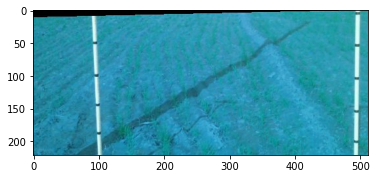

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img=cv2.imread('/content/Images/01B4CV3K.jpeg')
# img=cv2.resize(img,(224,224))
cv2_imshow(img)
# plt.imshow(img)

In [ ]:
#Importing The REquired Libraries
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tqdm import tqdm
import PIL 
from PIL import Image

img_h,img_w= (320,640)
train_img=[]
train_label=[]
j=0
path='/content/Images'

for i in tqdm(train['UID']):
    if train['label_quality'][j]==2:
          final_path=os.path.join(path,i)
          final_path = final_path + '.jpeg'
          img=cv2.imread(final_path)
          img=cv2.resize(img,(img_w,img_h))
          train_img.append(img)
          train_label.append(train['growth_stage'][j])
    j = j+1  

100%|██████████| 10695/10695 [00:06<00:00, 1546.53it/s]


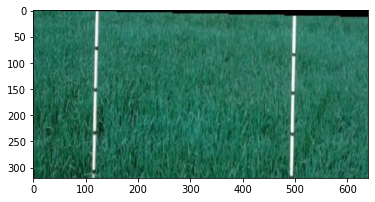

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_img[0])

In [ ]:
X = np.array(train_img)
Y = np.array(train_label)

from numpy import argmax
from tensorflow.keras.utils import to_categorical
# one hot encoding
Y = Y - 1
Y = to_categorical(Y)
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

inputs = layers.Input(shape=(img_w,img_h, 3))
model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# unfreeze the top 20 layers while leaving BatchNorm layers frozen
for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True


# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2, name="top_dropout")(x)
x = layers.Dense(256, activation='relu', name = 'top_Dense')(x)
x = layers.Dropout(0.2, name="top_dropout2")(x)
x = layers.Dense(32, activation='relu', name = 'top_Dense2')(x)
x = layers.Dropout(0.2, name="top_dropout3")(x)
outputs = layers.Dense(7, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
    optimizer=optimizer, loss = tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),"accuracy"]
)




In [ ]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 640, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 640, 320, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 640, 320, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 641, 321, 3)  0           normalization_3[0][0]            
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint('model.h5',save_weights_only=False,monitor='val_loss',save_best_only=True,mode='auto')
es = EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=False)   

In [ ]:
# Train model
history = model.fit(X, Y,
              batch_size=16,
              epochs=100,
              validation_split=0.25,
              shuffle=True,
              callbacks = [mc, es],
              verbose=1)

Epoch 1/100
134/134 [==============================] - 123s 917ms/step - loss: 0.1138 - rmse: 0.3373 - accuracy: 0.4678 - val_loss: 0.0917 - val_rmse: 0.3028 - val_accuracy: 0.5546
Epoch 2/100
134/134 [==============================] - 118s 884ms/step - loss: 0.1006 - rmse: 0.3172 - accuracy: 0.5635 - val_loss: 0.0700 - val_rmse: 0.2645 - val_accuracy: 0.6807
Epoch 3/100
134/134 [==============================] - 117s 871ms/step - loss: 0.0912 - rmse: 0.3020 - accuracy: 0.6064 - val_loss: 0.0954 - val_rmse: 0.3088 - val_accuracy: 0.5924
Epoch 4/100
134/134 [==============================] - 117s 871ms/step - loss: 0.0890 - rmse: 0.2983 - accuracy: 0.6172 - val_loss: 0.1361 - val_rmse: 0.3689 - val_accuracy: 0.4888
Epoch 5/100
134/134 [==============================] - 119s 885ms/step - loss: 0.0829 - rmse: 0.2879 - accuracy: 0.6270 - val_loss: 0.0615 - val_rmse: 0.2480 - val_accuracy: 0.7045
Epoch 6/100
134/134 [==============================] - 117s 871ms/step - loss: 0.0744 - rmse: 0

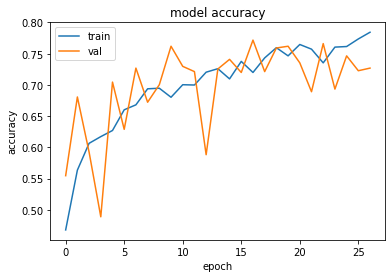

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [ ]:
# submission creation
submission = pd.read_csv('SampleSubmission.csv')

# img_h,img_w= (448,620)
test_img=[]
j=0
path='/content/Images'

for i in tqdm(submission['UID']):
    final_path=os.path.join(path,i)
    final_path = final_path + '.jpeg'
    img=cv2.imread(final_path)
    img=cv2.resize(img,(img_w,img_h))
    test_img.append(img)



100%|██████████| 3558/3558 [00:06<00:00, 542.00it/s]


In [ ]:
# predictions
test_img = np.array(test_img)
test_label = model.predict(test_img)

test_growth_rate = [] 
for i in test_label:
    test_growth_rate.append(argmax(i) + 1)


In [ ]:
submission['growth_stage'] = test_growth_rate
submission.to_csv('submission.csv',index = False)
submission

,UID,growth_stage
0,F3LbWkZq,4
1,6P4wLVzI,3
2,Tn6HIrdS,3
3,EYM5R1TK,4
4,fkcevlA0,4
...,...,...
3553,H9UastWl,4
3554,lXiDhZGC,4
3555,F0VDr9Zc,4
3556,3Fl5H12A,2
